<a href="https://colab.research.google.com/github/saurav3k2/Intro-to-PyTorch/blob/main/transfer_learning_fashion_mnist_pytorch_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
## set random seeds for reproducibility
torch.manual_seed(42)

In [ ]:
## check for GPU
device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
print(f"Using devide {device}")

Using devide cuda


In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(60000, 785)

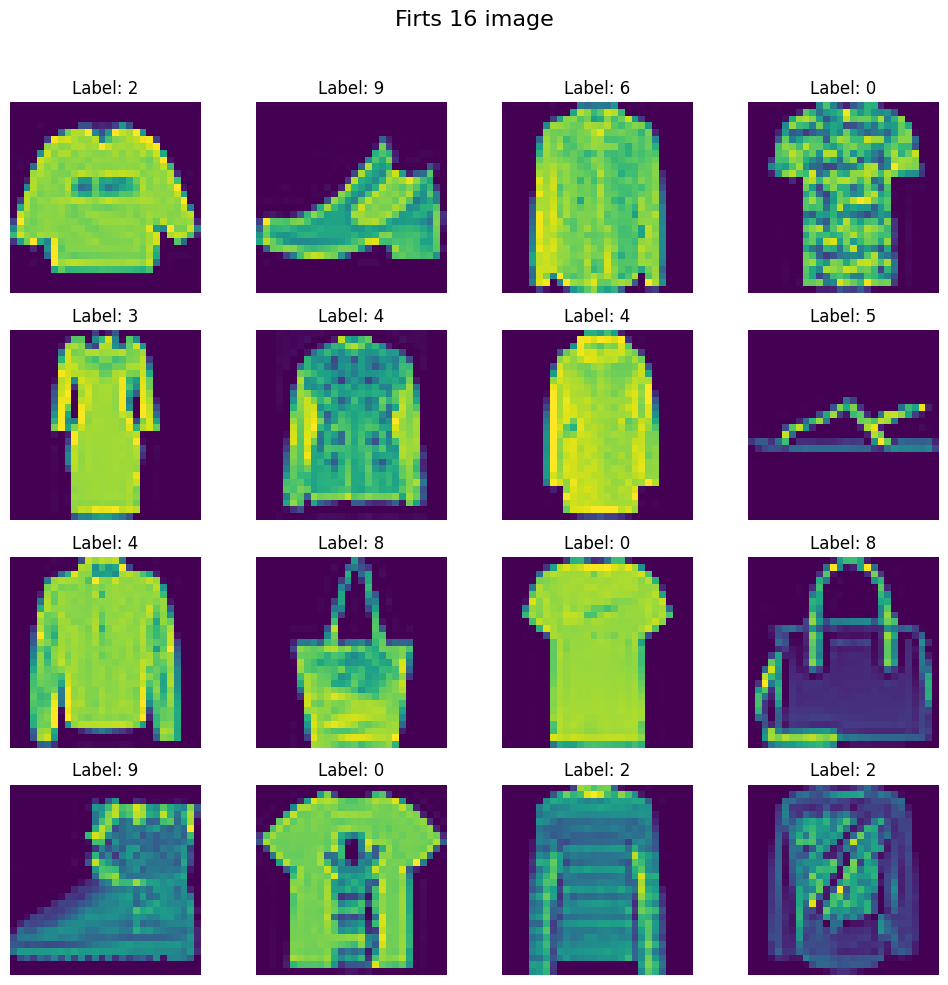

In [ ]:
## cerate a 4x$ grid of image
fig ,axes  = plt.subplots(4,4, figsize=(10,10))
fig.suptitle("Firts 16 image", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [ ]:
## train test split
X= df.iloc[:,1:].values
y= df.iloc[:,0].values

In [ ]:
X.shape

(60000, 784)

In [ ]:
y

array([2, 9, 6, ..., 8, 8, 7])

In [ ]:
X_train , X_test , y_train , y_test  = train_test_split(X,y, test_size =0.2 , random_state=42)

In [ ]:
## transformations
from torchvision import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
  def __init__(self, features , labels , transforms):
    self.features  = features
    self.labels = labels
    self.transforms = transforms

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    ##resize to (28 , 28)
    image = self.features[index].reshape(28,28)

    ##change datatype to np.uint8
    image = image.astype(np.uint8)

    ## change black&white to color --> (H,W,C) -->(C,H,W)
    image = np.stack([image]*3, axis = -1)

    ##convert array to PIL image
    image = Image.fromarray(image)

    ##apply transforms
    image = self.transforms(image)

    ## return
    return image , torch.tensor(self.labels[index],dtype=torch.long)

In [ ]:
train_dataset = CustomDataset(X_train , y_train , transforms=custom_transform)

In [ ]:
test_dataset = CustomDataset(X_test , y_test , transforms=custom_transform)

In [ ]:
train_loader = DataLoader(train_dataset , batch_size=32, shuffle=True , pin_memory=True)
test_loader = DataLoader(test_dataset , batch_size=32, shuffle=False , pin_memory=True)

In [ ]:
# fetch the pretrained model

import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
for param in vgg16.features.parameters():
  param.requires_grad = False

In [ ]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
vgg16.classifier  = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),

    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),

    nn.Dropout(0.5),
    nn.Linear(512,10),
)

In [ ]:
vgg16  = vgg16.to(device)

In [ ]:
leanring_rate = 0.0001
epochs = 100

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=leanring_rate)

In [ ]:
# Training loops
for epoch in range(epochs):
  total_epoch_loss  = 0
  for batch_features , batch_labels in train_loader:

    # move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # forward pass
    outputs = vgg16(batch_features)
    print(outputs.shape)
    print(batch_labels.shape)
    print("\n")

    ## calculate loss
    loss = criterion(outputs, batch_labels)

    ## back pass
    optimizer.zero_grad()

    total_epoch_loss = total_epoch_loss  + loss.item()

    break

  avg_loss  = total_epoch_loss/ len(train_loader)
  print(f"Epoch {epoch + 1} , loss:{avg_loss}")




torch.Size([32, 10])
torch.Size([32])


Epoch 1 , loss:0.001513930638631185
torch.Size([32, 10])
torch.Size([32])


Epoch 2 , loss:0.0015128194491068523
torch.Size([32, 10])
torch.Size([32])


Epoch 3 , loss:0.0015487915674845378
torch.Size([32, 10])
torch.Size([32])


Epoch 4 , loss:0.00155126953125
torch.Size([32, 10])
torch.Size([32])


Epoch 5 , loss:0.0015456555684407551
torch.Size([32, 10])
torch.Size([32])


Epoch 6 , loss:0.001542421023050944
torch.Size([32, 10])
torch.Size([32])


Epoch 7 , loss:0.0015493570963541667
torch.Size([32, 10])
torch.Size([32])


Epoch 8 , loss:0.001536913553873698
torch.Size([32, 10])
torch.Size([32])


Epoch 9 , loss:0.0015248201688130697
torch.Size([32, 10])
torch.Size([32])


Epoch 10 , loss:0.001541748046875
torch.Size([32, 10])
torch.Size([32])


Epoch 11 , loss:0.0015253508885701497
torch.Size([32, 10])
torch.Size([32])


Epoch 12 , loss:0.0015222711563110352
torch.Size([32, 10])
torch.Size([32])


Epoch 13 , loss:0.0015274632771809895
torch.S

In [ ]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.10458333333333333


In [ ]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.10997916666666667
